<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/optimized_position_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#참고 https://losskatsu.github.io/statistics/prob-distribution/#%EC%B0%B8%EA%B3%A0-%ED%99%95%EB%A5%A0%EB%B6%84%ED%8F%AC%EA%B0%84-%EA%B4%80%EA%B3%84%EB%8F%84

In [1]:
from google.colab import files
uploaded = files.upload()

Saving KOSDAQ.csv to KOSDAQ.csv


In [130]:
key = list(uploaded.items())[0][0]
key

'KOSDAQ.csv'

In [131]:
import io
import pandas as pd
import numpy as np
df = pd.read_csv(io.BytesIO(uploaded[key]))
df

,Unnamed: 0,Close,Change,Volume,Value
0,1996-07-02,"1,001.70",+0.17%,143,"1,533"
1,1996-07-03,"1,005.30",+0.36%,115,"1,012"
2,1996-07-04,"1,018.40",+1.30%,235,"5,247"
3,1996-07-05,"1,037.80",+1.90%,59,894
4,1996-07-06,"1,048.80",+1.06%,34,338
...,...,...,...,...,...
6222,2021-04-12,"1,000.65",+1.14%,"1,910,152","11,840,390"
6223,2021-04-13,"1,010.37",+0.97%,"3,655,477","14,516,838"
6224,2021-04-14,"1,014.42",+0.40%,"3,177,259","13,053,979"
6225,2021-04-15,"1,013.90",-0.05%,"2,618,274","13,132,193"


In [132]:
# Formatting
df = df.rename(columns={'Unnamed: 0':'Date'})
for i in df:
  try:
    df[i] = list(map(lambda a : float(str(a).replace(',','')) , df[i].values))
  except:
    pass
df['Change'] = list(map(lambda a : float(eval(str(100) + a.replace('%',''))/100),df['Change'].values))
df

,Date,Close,Change,Volume,Value
0,1996-07-02,1001.70,1.0017,143.0,1533.0
1,1996-07-03,1005.30,1.0036,115.0,1012.0
2,1996-07-04,1018.40,1.0130,235.0,5247.0
3,1996-07-05,1037.80,1.0190,59.0,894.0
4,1996-07-06,1048.80,1.0106,34.0,338.0
...,...,...,...,...,...
6222,2021-04-12,1000.65,1.0114,1910152.0,11840390.0
6223,2021-04-13,1010.37,1.0097,3655477.0,14516838.0
6224,2021-04-14,1014.42,1.0040,3177259.0,13053979.0
6225,2021-04-15,1013.90,0.9995,2618274.0,13132193.0


In [133]:
df['Volume_change'] = np.insert((df['Volume'][1:].values / df['Volume'][:-1].values), 0, 0)
df['Value_change'] = np.insert((df['Value'][1:].values / df['Value'][:-1].values), 0, 0)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


,Date,Close,Change,Volume,Value,Volume_change,Value_change
0,1996-07-02,1001.70,1.0017,143.0,1533.0,0.000000,0.000000
1,1996-07-03,1005.30,1.0036,115.0,1012.0,0.804196,0.660144
2,1996-07-04,1018.40,1.0130,235.0,5247.0,2.043478,5.184783
3,1996-07-05,1037.80,1.0190,59.0,894.0,0.251064,0.170383
4,1996-07-06,1048.80,1.0106,34.0,338.0,0.576271,0.378076
...,...,...,...,...,...,...,...
6222,2021-04-12,1000.65,1.0114,1910152.0,11840390.0,1.198779,1.066184
6223,2021-04-13,1010.37,1.0097,3655477.0,14516838.0,1.913710,1.226044
6224,2021-04-14,1014.42,1.0040,3177259.0,13053979.0,0.869178,0.899230
6225,2021-04-15,1013.90,0.9995,2618274.0,13132193.0,0.824067,1.005992


In [ ]:
# 샘플링

sampled_df = df.sample(n=1000)
# sampled_df = df

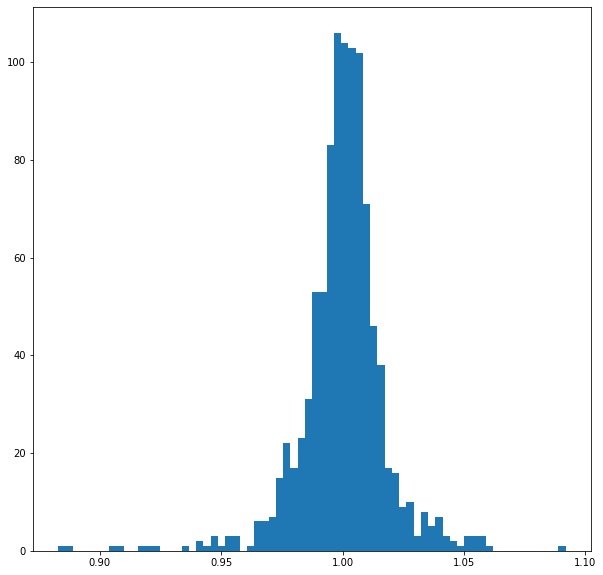

In [134]:
# 확률분포

import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 10))
plt.hist(sampled_df['Change'], bins='auto')
plt.show()

In [191]:
print('lowest 5th percentile: ', round(np.percentile(sampled_df['Change'], 5), 5))
print('highest 5th percentile: ', round(np.percentile(sampled_df['Change'], 95), 5))
print(sum(sampled_df['Change'] > 1.0) / len(sampled_df['Change']))

lowest 5th percentile:  0.97488
highest 5th percentile:  1.02623
0.531


In [138]:
# sampled_df의 Change > 1 전날의 데이터 인덱스
pre_increase = df.iloc[(sampled_df['Change'] > 1).index]['Change'].index[1:] - 1

In [139]:
# 전날 특성상 상승할 확률
print(sum(df.loc[pre_increase]['Change'] > 1) / len(pre_increase))
print(sum(df.loc[pre_increase]['Volume_change'] < 1) / len(pre_increase))

0.5255255255255256

In [220]:
# 기하분포
# 성공의 확률인 p인 독립시행을 성공이 나올 때까지 계속한다고 할 때, 처음 성공까지 총 시도한 횟수 X의 확률분포.
# Pr(X = x) = p*(1-p)^(x-1)
# 𝝁   : 1/p  
# 𝝈^2 : (1-p)/p^2

p = sum(sampled_df['Change'] > 1.02) / len(sampled_df['Change'])
print('p: ', p)
print('mean: ', 1/p)
print('variance: ', (1-p)/(p**2))

p:  0.076
mean:  13.157894736842106
variance:  159.97229916897507


In [217]:
from scipy.stats import geom
rv = geom(p=p)  
rv.pmf(5) 

0.055398942821376

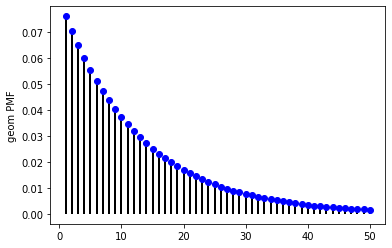

In [218]:
import matplotlib.pyplot as plt
import numpy as np
rv = geom(p) 
x = np.arange(1, 50+1)
pmf_geom = rv.pmf(x)
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.plot(x, pmf_geom, 'bo')
ax.vlines(x, 0, pmf_geom, lw =2)
ax.set_ylabel('geom PMF')
plt.show()

In [ ]:
# 음이항분포
# 베르누이시행에서 r번째 성공까지 시도한 횟수 X의 분포


In [223]:


n, p = 0.4, 0.4
mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')

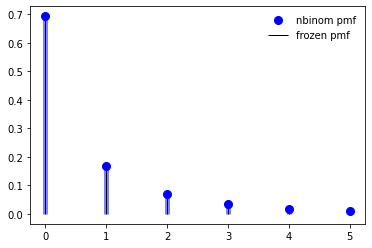

In [224]:
from scipy.stats import nbinom
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

x = np.arange(nbinom.ppf(0.01, n, p),
              nbinom.ppf(0.99, n, p))
ax.plot(x, nbinom.pmf(x, n, p), 'bo', ms=8, label='nbinom pmf')
ax.vlines(x, 0, nbinom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = nbinom(n, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()